In [1]:
import torch
from torch import nn
from torch.optim import Adam
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time
from skimage.transform import resize

device = "cuda" if torch.cuda.is_available() else "cpu"

data_df = pd.read_csv("/kaggle/input/quran-recitations-for-audio-classification/files_paths.csv")
data_df["FilePath"] = "/kaggle/input/quran-recitations-for-audio-classification/Dataset" + data_df["FilePath"].str[1:]

label_encoder = LabelEncoder()
data_df["Class"] = label_encoder.fit_transform(data_df["Class"])

train = data_df.sample(frac = 0.7, random_state = 7)
test = data_df.drop(train.index)
val = test.sample(frac = 0.5, random_state = 7)
test = test.drop(val.index)

In [2]:
class CustomAudioDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.labels = torch.tensor(list(dataframe["Class"]), dtype=torch.long)  # keep on CPU
        self.audios = [
            torch.tensor(self.get_spectrogram(path), dtype=torch.float32)
            for path in dataframe["FilePath"]
        ]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio = self.audios[idx].unsqueeze(0)  # add channel dim
        label = self.labels[idx]
        return audio, label

    def get_spectrogram(self, file_path):
        sr = 22050
        duration = 5
        img_height = 128
        img_width = 256
        signal, sr = librosa.load(file_path, sr=sr, duration=duration)
        spec = librosa.feature.melspectrogram(
            y=signal, sr=sr, n_fft=2048, hop_length=512, n_mels=128
        )
        spec_db = librosa.power_to_db(spec, ref=np.max)
        # Fix length along time axis
        spec_fixed = librosa.util.fix_length(spec_db, size=(duration * sr) // 512 + 1, axis=1)
        spec_resized = resize(spec_fixed, (img_height, img_width), anti_aliasing=True)
        return spec_resized

In [3]:
train_dataset = CustomAudioDataset(dataframe = train)
val_dataset = CustomAudioDataset(dataframe = val)
test_dataset = CustomAudioDataset(dataframe = test)

lr = 1e-4
batch_size = 16
epochs = 25

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(16,32, kernel_size = 3, padding =1)
        self.conv3 = nn.Conv2d(32,64, kernel_size = 3, padding = 1)
        self.pooling = nn.MaxPool2d(2,2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64 * 16 * 32, 4096)
        self.linear2 = nn.Linear(4096, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.output = nn.Linear(512, len(data_df["Class"].unique()))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.pooling(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.dropout(x)
        x = self.output(x)
        return x     

In [6]:
model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = lr)

total_loss_train_plot = []
total_loss_val_plot = []
total_acc_train_plot = []
total_acc_val_plot = []

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    # ---- Training ----
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        train_loss.backward()
        optimizer.step()

        train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_acc_train += train_acc

    # ---- Validation ----
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
            total_acc_val += val_acc

    # ---- Logging ----
    total_loss_train_plot.append(round(total_loss_train/len(train_loader), 4))
    total_loss_val_plot.append(round(total_loss_val/len(val_loader), 4))
    total_acc_train_plot.append(round((total_acc_train/len(train_dataset))*100, 4))
    total_acc_val_plot.append(round((total_acc_val/len(val_dataset))*100, 4))

    print(f"Epoch: {epoch+1}/{epochs} "
          f"Train Loss: {total_loss_train/len(train_loader):.4f}, "
          f"Train Acc: {(total_acc_train/len(train_dataset))*100:.2f}%, "
          f"Val Loss: {total_loss_val/len(val_loader):.4f}, "
          f"Val Acc: {(total_acc_val/len(val_dataset))*100:.2f}%")

Epoch: 1/25 Train Loss: 1.7729, Train Acc: 51.87%, Val Loss: 0.3500, Val Acc: 87.74%
Epoch: 2/25 Train Loss: 0.3366, Train Acc: 89.96%, Val Loss: 0.1965, Val Acc: 94.32%
Epoch: 3/25 Train Loss: 0.1715, Train Acc: 94.49%, Val Loss: 0.1201, Val Acc: 96.11%
Epoch: 4/25 Train Loss: 0.1405, Train Acc: 96.05%, Val Loss: 0.2811, Val Acc: 92.02%
Epoch: 5/25 Train Loss: 0.1588, Train Acc: 95.64%, Val Loss: 0.1509, Val Acc: 96.51%
Epoch: 6/25 Train Loss: 0.1020, Train Acc: 97.31%, Val Loss: 0.1691, Val Acc: 95.41%
Epoch: 7/25 Train Loss: 0.0697, Train Acc: 98.31%, Val Loss: 0.2375, Val Acc: 93.62%
Epoch: 8/25 Train Loss: 0.1032, Train Acc: 97.35%, Val Loss: 0.1513, Val Acc: 95.81%
Epoch: 9/25 Train Loss: 0.0932, Train Acc: 97.54%, Val Loss: 0.1539, Val Acc: 96.31%
Epoch: 10/25 Train Loss: 0.1405, Train Acc: 96.84%, Val Loss: 0.1369, Val Acc: 96.41%
Epoch: 11/25 Train Loss: 0.0464, Train Acc: 98.61%, Val Loss: 0.1260, Val Acc: 97.41%
Epoch: 12/25 Train Loss: 0.0677, Train Acc: 98.29%, Val Loss: 0

In [7]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        prediction = model(inputs)
        acc = (torch.argmax(prediction, axis = 1) == labels).sum().item()
        total_acc_test += acc

print(f"Total Accuracy Score is: {round((total_acc_test/test_dataset.__len__()*100), 4)}")

Total Accuracy Score is: 96.6102


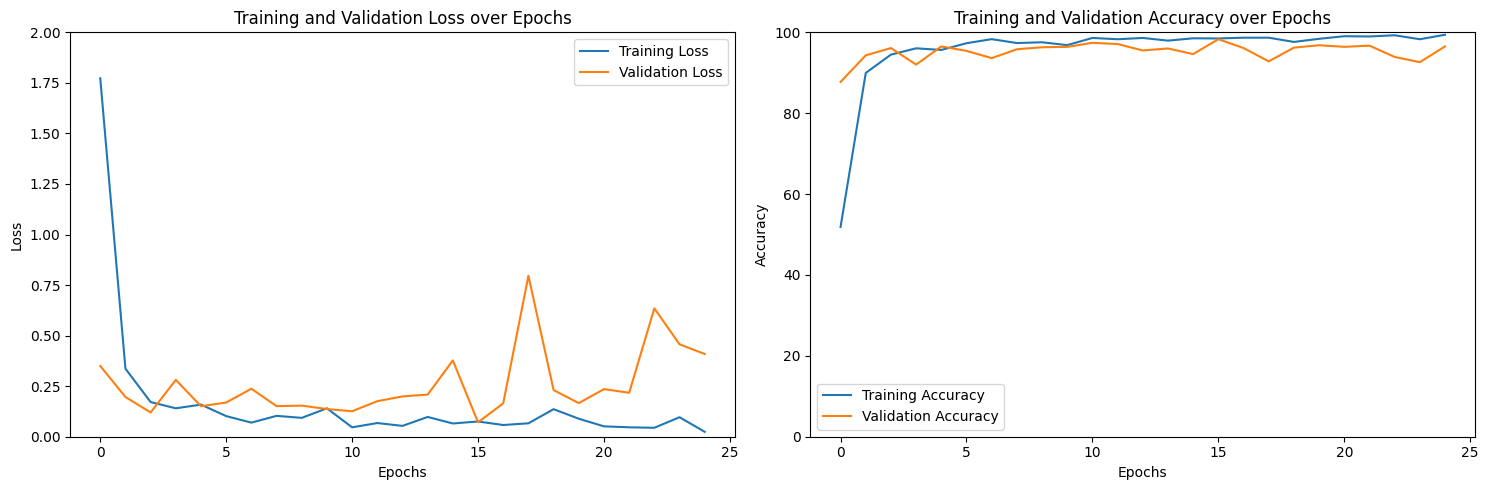

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_val_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Accuracy")
axs[1].plot(total_acc_val_plot, label = "Validation Accuracy")
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.tight_layout() 
plt.show()